<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Implementing-and-training-a-one-hidden-layer-fully-connected-network-to-classify-MNIST-digits-using-PyTorch." data-toc-modified-id="Implementing-and-training-a-one-hidden-layer-fully-connected-network-to-classify-MNIST-digits-using-PyTorch.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementing and training a one hidden layer fully-connected network to classify MNIST digits using PyTorch.</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Defining-a-model" data-toc-modified-id="Defining-a-model-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Defining a model</a></span></li><li><span><a href="#Fetching-data" data-toc-modified-id="Fetching-data-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Fetching data</a></span></li><li><span><a href="#Running-the-training-loop" data-toc-modified-id="Running-the-training-loop-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Running the training loop</a></span></li><li><span><a href="#Saving-and-loading-model-weights" data-toc-modified-id="Saving-and-loading-model-weights-1.0.4"><span class="toc-item-num">1.0.4&nbsp;&nbsp;</span>Saving and loading model weights</a></span></li></ul></li></ul></li></ul></div>

# Implementing and training a one hidden layer fully-connected network to classify MNIST digits using PyTorch.

This notebook illustrates how we would iterate through the following workflow in PyTorch:
* Defining a model
* Fetching batches of training data
* Obtaining model predictions
* Computing the loss
* Computing gradient of the loss wrt model parameters
* Updating the model parameters using some gradient-based optimization method.

Acknowledgments: based on official PyTorch tutorials.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

# You should set a random seed to ensure that your results are reproducible.
torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
    
print("Using GPU: {}".format(use_cuda))

Using GPU: True


### Defining a model

It's usually a good idea to define your model as classes which inherit from `nn.Module`. The parameters of any submodules of the `torch.nn` module that you declare attributes of the class (e.g. `nn.Linear` below) will automatically be registered as parameters of your model, which will prove to be convenient when constructing an optimizer, as we shall see below.

In [2]:
class OneHiddenLayerMNISTClassifier(nn.Module):
    # Define entities containing model weights in the constructor.
    def __init__(self, n_hidden):
        super().__init__()
        self.linear1 = nn.Linear(
            in_features=784, out_features=n_hidden, bias=True
        )
        self.linear2 = nn.Linear(
            in_features=n_hidden, out_features=10, bias=True
        )

    # Then, all you need to do is implement a `forward` method to define the
    # computation that takes place on the forward pass. A corresponding
    # `backward` method, which computes gradients, is automatically defined!
    def forward(self, inputs):
        h = self.linear1(inputs.view(-1, 784))
        h = F.relu(h)
        h = self.linear2(h)
        return F.log_softmax(h, dim=1)

In [9]:
# (B, 1, 28, 28) -> (B, 784), B = batch number,
# is obtained via view(-1,784)

We'll also define some utility functions that perform a single iteration of training and evalution:

In [ ]:
def train(model, train_loader, optimizer, epoch, log_interval=100):
    """
    A utility function that performs a basic training loop.

    For each batch in the training set, fetched using `train_loader`:
        - Zeroes the gradient used by `optimizer`
        - Performs forward pass through `model` on the given batch
        - Computes loss on batch
        - Performs backward pass
        - `optimizer` updates model parameters using computed gradient

    Prints the training loss on the current batch every `log_interval` batches.
    """
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # We need to send our batch to the device we are using. If this is not
        # it will default to using the CPU.
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Zeroes the gradient used by `optimizer`; NOTE: if this is not done,
        # then gradients will be accumulated across batches!
        optimizer.zero_grad()

        # Performs forward pass through `model` on the given batch; equivalent
        # to `model.forward(inputs)`. Any information needed to compute
        # gradients is automatically thanks to autograd running under the hood.
        outputs = model(inputs)

        # Computes loss on batch; `F.nll_loss` computes the mean negative log-
        # likelihood on the batch.
        loss = F.nll_loss(outputs, targets)

        # Performs backward pass; steps backward through the computation graph,
        # computing the gradient of the loss wrt model parameters.
        loss.backward()

        # `optimizer` updates model parameters using computed gradient.
        optimizer.step()

        # Prints the training loss on the current batch every `log_interval`
        # batches.
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {:02d} -- Batch: {:03d} -- Loss: {:.4f}".format(
                    epoch,
                    batch_idx,
                    # Calling `loss.item()` returns the scalar loss as a Python
                    # number.
                    loss.item(),
                )
            )


def test(model, test_loader):
    """
    A utility function to compute the loss and accuracy on a test set by
    iterating through the test set using the provided `test_loader` and
    accumulating the loss and accuracy on each batch.
    """
    test_loss = 0.0
    correct = 0

    # You should use the `torch.no_grad()` context when you want to perform a
    # forward pass but do not need gradients. This effectively disables
    # autograd and results in fewer resources being used to perform the forward
    # pass (since information needed to compute gradients is not logged).
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            # We use `reduction="sum"` to aggregate losses across batches using
            # summation instead of taking the mean - we will take the mean at
            # the end once we have accumulated all the losses.
            test_loss += F.nll_loss(outputs, targets, reduction="sum").item()
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(targets.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(
        "\nTest set: Average loss: {:.4f}, Accuracy: {:.4f}\n".format(
            test_loss, correct / len(test_loader.dataset)
        )
    )

### Fetching data

* https://pytorch.org/docs/stable/data.html
* https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...



Done!
5


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



torch.Size([1, 28, 28])


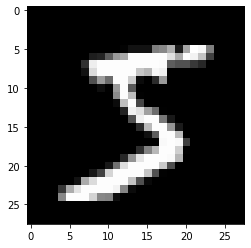

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

train_dat = datasets.MNIST(
    "data/", train=True, download=True, transform=transform
)
test_dat = datasets.MNIST("data/", train=False, transform=transform)

sample_image, sample_target = train_dat[0]

print(sample_target)
plt.imshow(sample_image.squeeze(), cmap='gray')

print(sample_image.shape)

In [11]:
# Create dataloaders
train_loader = DataLoader(train_dat, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dat, batch_size=1024, shuffle=False)

it = iter(train_loader)
sample_inputs, sample_targets = next(it) # get one item from iterator

print(sample_inputs.shape, sample_targets.shape, '\n')
print(sample_inputs)
print(sample_targets)

torch.Size([64, 1, 28, 28]) torch.Size([64]) 

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242

### Running the training loop

In [ ]:
# Create instance of model; we also need to call `.to(device)` to
# indicate the device we would like to use. This defaults to CPU if
# not specified.
model = OneHiddenLayerMNISTClassifier(n_hidden=32).to(device)

# Create instance of optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Train-test loop
for epoch in range(3):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

### Saving and loading model weights

In [ ]:
# Saving / restoring model weights
torch.save(model.state_dict(), "mnist_fc_model.pt")
model.load_state_dict(torch.load("mnist_fc_model.pt"))